# Noisy generative processes

Creates the plot at the beginning of Chapter 2 showing how you can add noise to a linear function to generate points normally distributed across a line. 

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys

from scipy.stats import norm

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.utils import create_environment

mpl.style.use("seaborn-deep")

## Define the environment and helper functions

First, we use 49 different external states of the environment and use them to generate sensory data. The external states are mapped to sensory data using the generating function $y = 2x^*+3$ with added Gaussian noise. This generating function is captured in code as the function $y = \beta_1^* x^* + \beta_0^*$, with $\beta_0^* =3$ and $\beta_1^*=2$ as explained in the Chapter 2 notebooks. We use this package's environment constructor to create an environment that generates sensory data based on this linear generating function.

**Note**: 49 points are chosen because later we make use of the `np.median()` function and we want an odd number of points so we can select a single value for the median.

Below we create helper function specifies the generating function and its inverse. These helper functions will be used later during plotting.

In [2]:
""" Helper functions """

# Generating function
def ge(x_star, beta_0_star, beta_1_star):
    y = beta_1_star * x_star + beta_0_star
    return y

# Inverse generating function which can return the original state that generated the observation
def ge_inv(y, beta_0_star, beta_1_star):
    x_star = (y - beta_0_star) / beta_1_star
    return x_star

Now we set up the simulation. First, we need to specify the parameters for the environment. Here there are just three variables to consider: $\beta_0^*, \beta_1^*, {\sigma^2_y}^*$.

The simulation setup includes a random key, the support or range of values considered by $x^*$, and $n=49$ possible values of $x^*$ to randomly generate.

Finally, we initialize the sensory data array with zeros so it can be filled when the samples are generated.

In [3]:
""" Setup environment and generate data """
# Environment parameters
env_params = {
    "beta_0_star" : 3,    # Linear parameter intercept
    "beta_1_star" : 2,    # Linear parameter slope
    "y_star_std"  : 1  # Standard deviation of sensory data
}

# Initialize environment and agent
env = create_environment(name="static_linear", params=env_params)

# Generate data for three different x_star values
np.random.seed(34567)
N       = 49                                         # Number of samples
x_range = np.linspace(start=0.01, stop=5, num=500)   # Range of x_star
x_star  = np.random.choice(x_range, size=49)         # N random external states
y       = np.zeros(N)                                # Empty array for N=49 samples

Here we loop across the different external states in the $x^*$ vector, create a random subkey for each one, and step through the environment each time to generate the sensory data.

In [4]:
# Generate N=30 samples
for idx, x in enumerate(x_star):
    env.build(x)
    y[idx] = env.generate()

## Generate data to plot

The code here is used to generate the Gaussian distribution that will appear in the plot.

In [5]:
# Generate the distribution around noise
point_x = np.median(x_star)                          # x coordinate of a chosen sampled point
y_mean = ge(point_x, beta_0_star=3, beta_1_star=2)   # y coordinate at chosen sampled point

# Calculate the y-range to use in plotting
y_range = np.linspace(start=0.01, stop=12, num=500)

# Create the PDF for plotting around the selected point via the CDF
norm_cdf = norm.cdf(y_range, y_mean, env_params["y_star_std"])
norm_pdf = np.diff(norm_cdf) / (y_range[1] - y_range[0])  # PDF = derivative of CDF

# Replace 0s with NaN so that they are not plotted
norm_pdf[norm_pdf == 0] = np.nan
norm_pdf = np.append(norm_pdf, np.NaN)

# Inverse mapping of point_x
point_y = dict(zip(x_star, y))[np.median(x_star)]

## Plot the data points.

The plot is composed of multiple elements:
1. The samples from the noisy generative process. These are just the data points we generated with the `environment()` function.
2. The actual linear generating function (no noise). This is just the line $y= 2x+3$.
3. A normal distribution around a chosen sampled point. This uses the median function to pick a point in the middle of the plot (just so the plot is centered). Then a distribution is drawn around it to indicate that points sampled on the line here could fall in $\pm y$ range. To create the distribution we just create the CDF of the normal distribution at that point and then take the derivative to get the PDF.
4. Dotted "boundary lines" are added to show the $x$ and $y$ coordinates around the point on the line.
5. A red line is drawn to show how the noise has offset the point from the mean.

<Figure size 432x288 with 0 Axes>

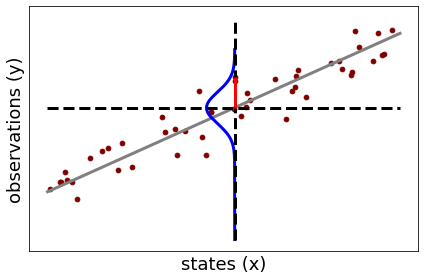

In [6]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Plot (1): Samples from probabilistic generative process
ax.scatter(x_star, y,
           s=22,
           c="maroon")

# Plot (2): Deterministic (linear) generating function
ax.plot(x_range.tolist(), [ge(elem, beta_0_star=3, beta_1_star=2) for elem in x_range],
        c="gray",
        linewidth=3)

# Plot (3): Normal distribution around the sampled point
ax.plot(-norm_pdf + ge_inv(y_mean, beta_0_star=3, beta_1_star=2), y_range,
        c="blue",
        linewidth=3)

# Plot (4): Boundary lines
ax.hlines(y=y_mean, xmin=0, xmax=5, 
          linestyle="dashed", 
          colors="black", 
          linewidth=3)

ax.vlines(x=ge_inv(y_mean, beta_0_star=3, beta_1_star=2), 
          ymin=0, ymax=14, 
          linestyle="dashed", 
          colors="black",
          linewidth=3)

# Plot (5): Error/offset for the samples point
ax.vlines(x=ge_inv(y_mean, beta_0_star=3, beta_1_star=2), 
          ymin=point_y, ymax=y_mean, 
          colors="red",
          linewidth=3)

# Axis labels and stylizing
ax.set_xlabel("states (x)", fontsize=18)
ax.set_ylabel("observations (y)", fontsize=18)
ax.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    left=False,         
    labelbottom=False,
    labelleft=False)

fig.tight_layout()